In [287]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import csv

In [288]:
data_root_dir = './data/torobo/815_trajs_static'
obs_array = np.load(data_root_dir + '/obs.npy', allow_pickle=True, encoding='latin1')
# obs_array = np.squeeze(obs_array, axis=-1)
obs_array.shape

(59, 50, 3)

In [289]:
obs_array[0][1]

array([7,
       array([ 1.48140609,  0.91956967,  0.8183658 ,  1.82397544, -1.17447614,
              -0.26428729,  0.78469582])                                      ,
       array([ 0.5 , -0.1 ,  1.15])], dtype=object)

In [290]:
episodes_list = []
for i in range(obs_array.shape[0]):
    timestep_list = []
    for j in range(obs_array.shape[1]):
        data_timestep = obs_array[i, j]
        timestep = data_timestep[0]
        joint_values = data_timestep[1]
        target_pos = data_timestep[2]
        tmp_list = [timestep]
        for k in range(joint_values.size):
            tmp_list.append(joint_values[k])
        for k in range(target_pos.size):
            tmp_list.append(target_pos[k])
        timestep_list.append(tmp_list)
        
    episodes_list.append(timestep_list)

In [291]:
torobo_data = np.array(episodes_list)
print(torobo_data.shape)

(59, 50, 11)


In [292]:
with open(data_root_dir + '/trajectories.npy', 'wb') as f:
    np.save(f, torobo_data)

In [293]:
with open(data_root_dir + '/trajectories.npy', 'rb') as f:
    torobo_data = np.load(f)
print(torobo_data.shape)
print(torobo_data.dtype)

(59, 50, 11)
float64


In [294]:
steps = torobo_data[:, :, 0]
joint_values = torobo_data[:, :, 1:8]
target_points = torobo_data[:, :, 8:]
print(steps.shape)
print(joint_values.shape)
print(target_points.shape)

(59, 50)
(59, 50, 7)
(59, 50, 3)


In [295]:
def calculate_vel_act(array, start_idx, end_idx):
    vel_episodes, act_episodes = [], []
    for i in range(array.shape[0]):
        vel_steps, act_steps = [], []
        for j in range(array.shape[1]):
            cur_vals = array[i][j][start_idx:end_idx]
            if j != 0:
                prev_vals = array[i][j-1][start_idx:end_idx]
            # else: prev_vals = np.zeros(end_idx-start_idx)
            else: 
                prev_vals = cur_vals

            if j != array.shape[1]-1:
                next_vals = array[i][j+1][start_idx:end_idx]
                act = next_vals - cur_vals

            vel_steps.append(cur_vals - prev_vals)
            act_steps.append(act)
        vel_episodes.append(vel_steps)
        act_episodes.append(act_steps)

    return np.array(vel_episodes), np.array(act_episodes)

In [296]:
velocs, acts = calculate_vel_act(torobo_data, 1, 8)
print(velocs.shape)
# torqs = calculate_torq_vel(velocs, 0, 7)
print(acts.shape)

(59, 50, 7)
(59, 50, 7)


In [297]:
states = np.concatenate((joint_values, velocs), axis=2)
print(states.shape)

(59, 50, 14)


In [298]:
# Calculate mean and standard deviation along the last dimension
mean = np.mean(states, axis=(0, 1))#, keepdims=True)
std = np.std(states, axis=(0, 1))#, keepdims=True)

# mean_10K = np.array([-0.00188743, 0.00013914, -0.00315345, 0.01042289])
# std_10K = np.array([0.91649005, 1.31088051, 2.16946285, 3.51440869])
print("mean", mean)
print("std", std)

with open(data_root_dir + "/stats.csv", 'w') as f:
    writer = csv.writer(f)
    row = ["ds_name", "mean", "std"]
    writer.writerow(row)

    row = ["torobo", str(mean), str(std)]
    writer.writerow(row)

normalized_states = (states - mean) / std
print(normalized_states.shape)

mean [ 9.25872825e-01  8.81683659e-01  5.33467716e-01  1.75751249e+00
 -1.85457166e+00 -5.47689931e-01  1.42597397e+00 -5.53580567e-03
 -7.88268924e-03  3.93743777e-03  8.09684977e-03 -1.04522312e-03
 -4.52608394e-03 -1.43228645e-03]
std [0.30745971 0.35611747 0.320233   0.20006721 0.44923591 0.31984338
 0.39227833 0.01303799 0.01743169 0.01808803 0.0093126  0.01849618
 0.01786414 0.01743166]
(59, 50, 14)


In [299]:
steps = steps[:, :, np.newaxis]
normalized_training_data = np.concatenate((steps, normalized_states), 
                                            axis=2)
normalized_training_data = np.concatenate((normalized_training_data, acts), #
                                            axis=2)
normalized_training_data = np.concatenate((normalized_training_data, target_points), 
                                            axis=2)                                            
print("normalized_training_data.shape:", normalized_training_data.shape)

# np.save(data_root_dir+"/trajectories.npy", trajectories)
np.save(data_root_dir+"/trajectories_normalized.npy", normalized_training_data)

normalized_training_data.shape: (59, 50, 25)


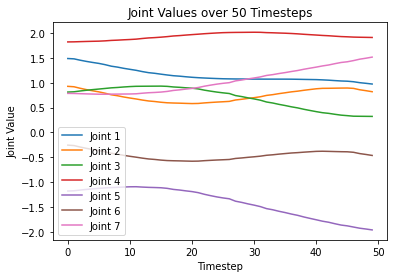

In [300]:
plot_data = torobo_data[0, :, 1:8]

# Create a figure and axis
fig, ax = plt.subplots()

# Plot each column in the array
for i in range(plot_data.shape[1]):
    ax.plot(plot_data[:, i], label=f'Joint {i+1}')

# Add labels and title
ax.set_xlabel('Timestep')
ax.set_ylabel('Joint Value')
ax.set_title('Joint Values over 50 Timesteps')
ax.legend()

# Show the plot
plt.show()


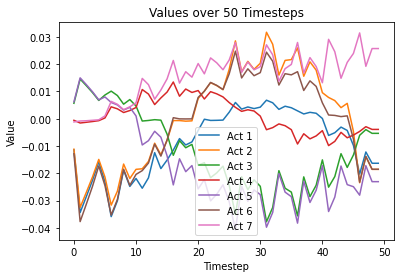

In [301]:
episode_no = 2
joints_plot = normalized_training_data[episode_no, :, 1:8]
velocs_plot = normalized_training_data[episode_no, :, 8:15]
acts_plot = normalized_training_data[episode_no, :, 15:22]

# Create a figure and axis
fig, ax = plt.subplots()

# Plot each column in the array
#for i in range(joints_plot.shape[1]):
#    ax.plot(joints_plot[:, i], label=f'Joint {i+1}')
    #break
#for i in range(velocs_plot.shape[1]):
#    ax.plot(velocs_plot[:, i], label=f'Veloc {i+1}', linestyle='--')
    #break
for i in range(acts_plot.shape[1]):
    ax.plot(acts_plot[:, i], label=f'Act {i+1}', linestyle='-')
    #break

# Add labels and title
ax.set_xlabel('Timestep')
ax.set_ylabel('Value')
ax.set_title('Values over 50 Timesteps')
ax.legend()

# Show the plot
plt.show()


In [302]:
torobo_data[30]

array([[ 6.00000000e+00,  8.28209583e-01,  1.38190966e+00,
        -4.05823851e-02,  1.25183419e+00, -2.36257585e+00,
        -3.39350792e-01,  1.94983138e+00,  5.00000000e-01,
        -1.57357644e-01,  1.33191520e+00],
       [ 7.00000000e+00,  8.31123057e-01,  1.38495103e+00,
        -4.08570763e-02,  1.25304608e+00, -2.36107601e+00,
        -3.36728418e-01,  1.94728550e+00,  5.00000000e-01,
        -1.57357644e-01,  1.33191520e+00],
       [ 8.00000000e+00,  8.43043163e-01,  1.39542928e+00,
        -3.80608498e-02,  1.26081144e+00, -2.35226385e+00,
        -3.27076837e-01,  1.93342127e+00,  5.00000000e-01,
        -1.57357644e-01,  1.33191520e+00],
       [ 9.00000000e+00,  8.50183485e-01,  1.40170588e+00,
        -3.63859135e-02,  1.26546300e+00, -2.34698523e+00,
        -3.21295455e-01,  1.92511640e+00,  5.00000000e-01,
        -1.57357644e-01,  1.33191520e+00],
       [ 1.00000000e+01,  8.59539233e-01,  1.40993420e+00,
        -3.42000003e-02,  1.27155160e+00, -2.34007471e+00,
  

Target

In [303]:
target_points.shape

(59, 50, 3)

Text(0.5, 0, 'Z Label')

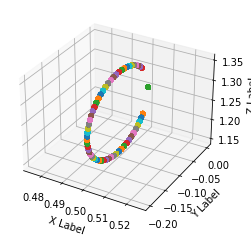

In [304]:
# Create a figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data points
for i in range(target_points.shape[0]):
    x = target_points[i, :, 0]
    y = target_points[i, :, 1]
    z = target_points[i, :, 2]
    ax.scatter(x, y, z)

# Set labels
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')